In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate

2023-10-22 13:12:03.625992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 13:12:07.149654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def json_to_dataset(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.head())
    f.close()
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    #df = df.iloc[:10000]
    print(df.columns)
    print(df.head)
    dataset = Dataset.from_pandas(df)
    dataset = dataset.train_test_split(test_size=0.2)
    return dataset

In [4]:
train_data = json_to_dataset('Train_Headline_Generation.json')

                                                news  \
0  (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...   
1  (Oct 29, 2013  8:15 AM CDT) Dax Shepard and Kr...   
2  (Mar 6, 2016  10:50 AM) Nancy Reagan, the help...   
3  (Aug 15, 2008  5:11 AM CDT) American Airlines ...   
4  (Apr 18, 2016  1:02 PM CDT) Ingrid Lyne, the S...   

                                            headline  
0   30K Walmart Part-Timers to Lose Health Insurance  
1     Dax Shepard: Wedding to Kristen Bell Cost $142  
2                            Nancy Reagan Dead at 94  
3  American Airlines Faces $7M Fine for Safety Vi...  
4   $222K Raised for Kids of Mom Dismembered on Date  
Index(['news', 'headline'], dtype='object')
<bound method NDFrame.head of                                                     news  \
0       As of Jan. 1, Walmart will no longer offer 30...   
1       Dax Shepard and Kristen Bell got married at t...   
2       Nancy Reagan, the helpmate, backstage adviser...   
3       American Ai

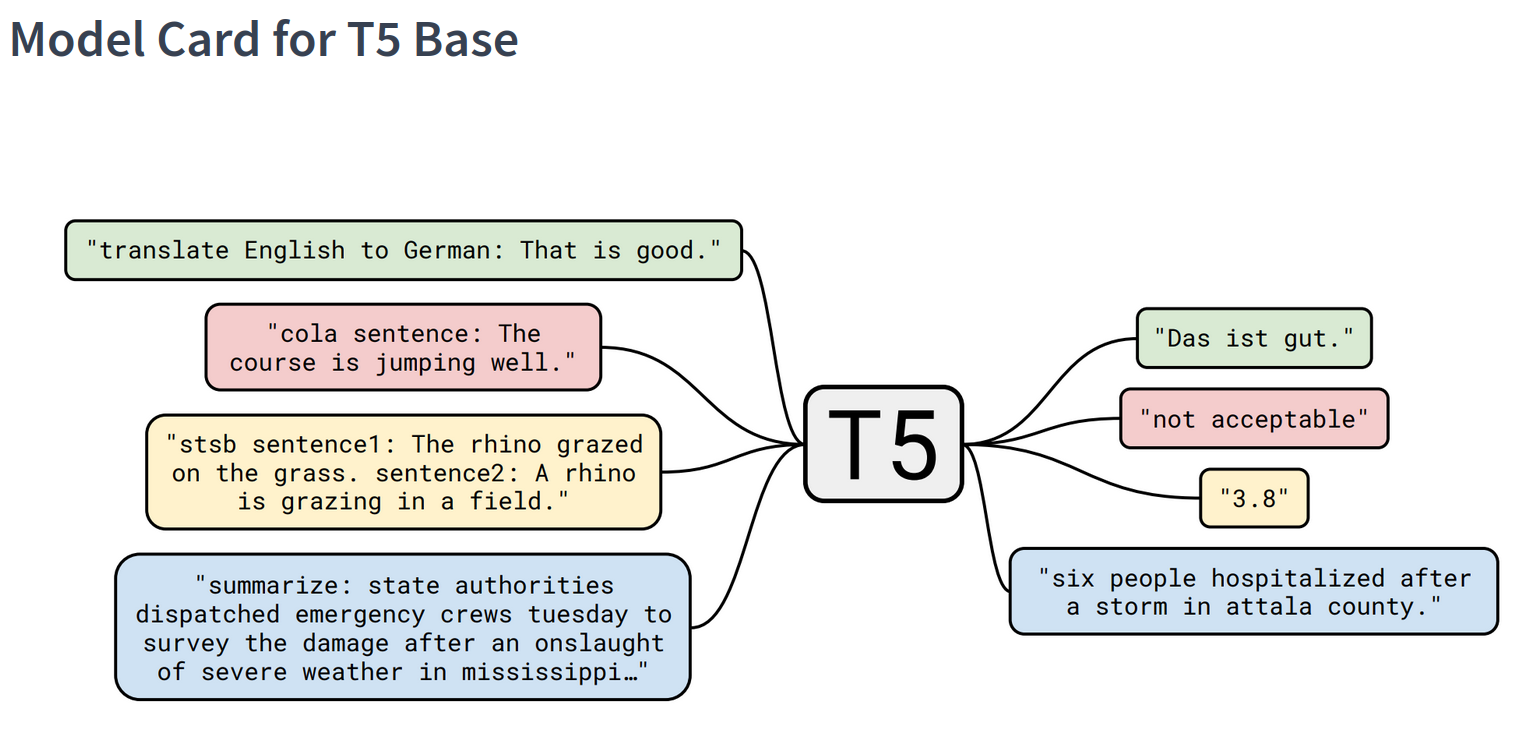

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [5]:
model_name = "czearing/article-title-generator"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

In [6]:
'''
model_names = ["it5/it5-base-headline-generation", 
               "it5/it5-small-headline-generation",
               "it5/mt5-base-headline-generation",
               "it5/mt5-small-headline-generation", 
               "it5/it5-efficient-small-el32-headline-generation",
               "Michau/t5-base-en-generate-headline"]
'''

'\nmodel_names = ["it5/it5-base-headline-generation", \n               "it5/it5-small-headline-generation",\n               "it5/mt5-base-headline-generation",\n               "it5/mt5-small-headline-generation", \n               "it5/it5-efficient-small-el32-headline-generation",\n               "Michau/t5-base-en-generate-headline"]\n'

To prefix the input with a prompt so T5 knows this is a headline generation task

In [6]:
prefix = "headline: "
#max_len = 3024
max_len = 2024
#max_l = 1028
max_l = 128

In [7]:
def preprocess_function(examples):   
    inputs = [prefix + doc for doc in examples["news"]]
    model_inputs = tokenizer(inputs, max_length=max_len, truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=max_l, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

To apply the preprocess function over the entire dataset

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
tokenized = train_data.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=train_data['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [10]:
#tokenized = train_data.map(preprocess_function, batched=True)

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
optimizer = AdamWeightDecay(learning_rate=3e-4, weight_decay_rate=0.007)

To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [11]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-10-22 13:13:27.577380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-10-22 13:13:27.578249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['lm_head.weight', 'encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

To convert datasets to the tf.data.Dataset format 

In [12]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
model.compile(optimizer=optimizer)

In [14]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 59s 190ms/step - loss: 2.5111
Pretrained LM Perplexity: 12.32


In [15]:
history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=3)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/3
1057/1057 [==============================] - 646s 591ms/step - loss: 2.0562 - val_loss: 1.7329
Epoch 2/3
1057/1057 [==============================] - 625s 591ms/step - loss: 1.6253 - val_loss: 1.6735
Epoch 3/3
1057/1057 [==============================] - 624s 590ms/step - loss: 1.3465 - val_loss: 1.6836


In [16]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 51s 192ms/step - loss: 1.6836
Finetuned LM Perplexity: 5.39


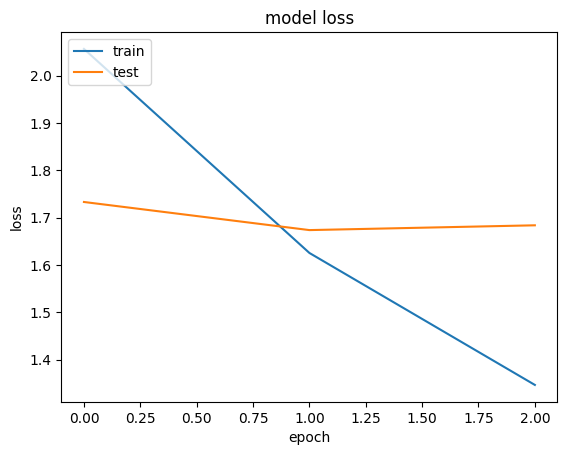

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
f = open('Dev_Headline_Generation.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
#df = df.iloc[45:50]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [19]:
def t5_predictions(data, tokenizer, model):
    text = prefix + data['news']
    inputs = tokenizer.encode_plus(text, return_tensors="pt").input_ids
    #input_ids = inputs['input_ids'].to(device)
    #attention_masks = inputs['attention_mask']
    
    outputs = model.generate(inputs,
                              max_length = 64, num_beams = 5, early_stopping = True)
    predictions = tokenizer.decode(outputs[0])
    result = re.sub("\<.*?\>","", predictions)
    return result

In [18]:
def t5_predictions(data, tokenizer, model):
    text = prefix + data['news']
    inputs = tokenizer.encode_plus(text, return_tensors="pt").input_ids
    #input_ids = inputs['input_ids'].to(device)
    #attention_masks = inputs['attention_mask']
    
    outputs = model.generate(inputs,top_k=5,do_sample=True,num_return_sequences = 5,
         max_length = 64, num_beams = 5, early_stopping = True)

    prediction1 = tokenizer.decode(outputs[0])
    prediction2 = tokenizer.decode(outputs[1])
    prediction3 = tokenizer.decode(outputs[2])
    prediction4 = tokenizer.decode(outputs[3])
    prediction5 = tokenizer.decode(outputs[4])
    result1 = re.sub("\<.*?\>","", prediction1)
    result2 = re.sub("\<.*?\>","", prediction2)
    result3 = re.sub("\<.*?\>","", prediction3)
    result4 = re.sub("\<.*?\>","", prediction4)
    result5 = re.sub("\<.*?\>","", prediction5)
    return result1, result2, result3, result4, result5

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [20]:
rouge = evaluate.load("rouge")

It shows the ratio of the number of unigrams in R that appear also in C over the number of unigrams in R.

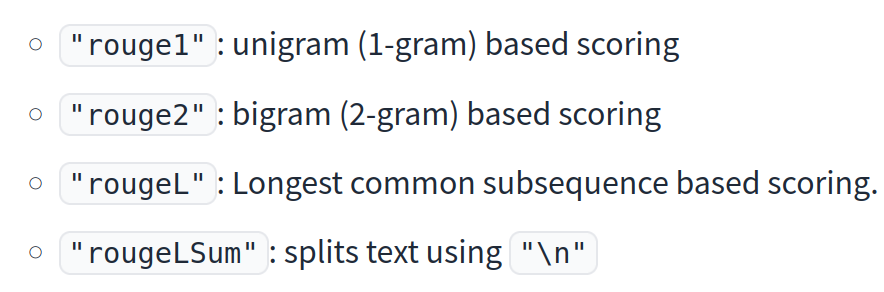

In [24]:

# learning_rate=2e-4

In [21]:
over50 = 0
over75 = 0
perfect = 0
for i in test_data:
    prediction = t5_predictions(i, tokenizer, model)
    answer = i['headline']
    print("Answer: ", answer)
    print("Prediction: ", prediction)
    results = rouge.compute(predictions=[prediction], references=[answer])
    print(results)
    if results['rougeL'] >= 0.5:
        over50 += 1
    if results['rougeL'] >= 0.75:
        over75 += 1  
    if results['rougeL'] == 1.0:
        perfect += 1
    print("")

2023-10-22 13:48:29.749666: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bc4ae2000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 13:48:29.749719: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-22 13:48:29.749726: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-22 13:48:29.753955: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 13:48:29.772395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-22 13:48:29.780219: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

Answer:  3rd Victim Dead in Quarry Shooting; Manhunt Still On
Prediction:   3 Dead, 5 Hurt in California Quarry Shooting Spree
{'rouge1': 0.4444444444444444, 'rouge2': 0.125, 'rougeL': 0.4444444444444444, 'rougeLsum': 0.4444444444444444}

Answer:  Stocks Up 305 in Election Rally
Prediction:   Dow Rises 305 on Election Day
{'rouge1': 0.3333333333333333, 'rouge2': 0.0, 'rougeL': 0.3333333333333333, 'rougeLsum': 0.3333333333333333}

Answer:  You Can Watch The Interview at 1pm
Prediction:   Sony to Release 'The Interview' for $14.99
{'rouge1': 0.26666666666666666, 'rouge2': 0.15384615384615383, 'rougeL': 0.26666666666666666, 'rougeLsum': 0.26666666666666666}

Answer:  Murder Suspect, 10, Will Stay in Adult Jail
Prediction:   10-Year-Old Confessional Killer Still in Adult Prison
{'rouge1': 0.35294117647058826, 'rouge2': 0.13333333333333333, 'rougeL': 0.35294117647058826, 'rougeLsum': 0.35294117647058826}

Answer:  Tobacco Firms Knew of Radiation in Cigs—in 1959
Prediction:   Tobacco Firms D

In [22]:
print("Over 50: ", over50)
print("Over 75: ", over75)
print("Perfect: ", perfect)

Over 50:  692
Over 75:  172
Perfect:  26


In [23]:
# learning_rate=3e-4

In [20]:
over50 = 0
over75 = 0
perfect = 0
for i in test_data:
    prediction1, prediction2, prediction3, prediction4, prediction5 = t5_predictions(i, tokenizer, model)
    answer = i['headline']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Prediction2: ", prediction2)
    print("Prediction3: ", prediction3)
    print("Prediction4: ", prediction4)
    print("Prediction5: ", prediction5)
    results = rouge.compute(predictions=[prediction1], references=[answer])
    print(results)
    if results['rougeL'] >= 0.5:
        over50 += 1
    if results['rougeL'] >= 0.75:
        over75 += 1  
    if results['rougeL'] == 1.0:
        perfect += 1
    print("")

2023-10-20 09:19:25.548290: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4e7001b620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-20 09:19:25.548342: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-20 09:19:25.548350: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-20 09:19:25.553385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-20 09:19:25.572006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-20 09:19:25.581349: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

Answer:  3rd Victim Dead in Quarry Shooting; Manhunt Still On
Prediction1:   3 Dead, 5 Wounded in California Quarry Shooting
Prediction2:   3 Dead, 5 Hurt in California Quarry Shooting
Prediction3:   3 Dead, 5 Wounded at California Quarry
Prediction4:   3 Dead in California Quarry Shooting
Prediction5:   3 Dead in California Quarry Shootings
{'rouge1': 0.47058823529411764, 'rouge2': 0.13333333333333333, 'rougeL': 0.47058823529411764, 'rougeLsum': 0.47058823529411764}

Answer:  Stocks Up 305 in Election Rally
Prediction1:   Dow Rises 305 on Election Day
Prediction2:   Dow Rises 300 on Election Day
Prediction3:   Dow Up 305 on Election Day
Prediction4:   Dow Rises 305 on Election Day News
Prediction5:   Dow Rises 305
{'rouge1': 0.3333333333333333, 'rouge2': 0.0, 'rougeL': 0.3333333333333333, 'rougeLsum': 0.3333333333333333}

Answer:  You Can Watch The Interview at 1pm
Prediction1:   Sony Announces $14.99 Movie
Prediction2:   Sony Announces $14.99 Movie to Kill Kim Jong Un
Prediction3:   

In [21]:
print("Over 50: ", over50)
print("Over 75: ", over75)
print("Perfect: ", perfect)

Over 50:  681
Over 75:  175
Perfect:  30


### References:
[1] Prakhar Mishra. 2020. Understanding T5 Model : Text to Text Transfer Transformer Model. Towards Data Science
https://towardsdatascience.com/understanding-t5-model-text-to-text-transfer-transformer-model-69ce4c165023.

[2] Summarization. Huggingface. https://huggingface.co/docs/transformers/tasks/summarization.

[3] Fabio Chiusano. 2022. Two minutes NLP — Learn the ROUGE metric by examples. Medium. https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499.